# import section

In [1]:
# Base
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchsummary import summary

# scikit-learn
from sklearn.metrics import confusion_matrix

# local files
from utils.wresnet import WideResNet

In [2]:
# fixed random seed to generate deterministic results.
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

In [3]:
# detect GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# loading dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean= (0.5, 0.5, 0.5), std= (0.5, 0.5, 0.5))
])

trainset = CIFAR10(root= "./dataset/", train= True , download= True, transform= transform)
testset  = CIFAR10(root= "./dataset/", train= False, download= True, transform= transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
print(f"trainset features: {trainset.data.shape}  |  trainset labels: {len(trainset.targets)}")
print(f"testset  features: {testset.data.shape }  |  estset labels  : {len(testset.targets)}")

trainset features: (50000, 32, 32, 3)  |  trainset labels: 50000
testset  features: (10000, 32, 32, 3)  |  estset labels  : 10000


In [6]:
train_idx = np.argsort(trainset.targets)
trainset.data = trainset.data[train_idx]
trainset.targets = list(np.array(trainset.targets)[train_idx])

test_idx = np.argsort(testset.targets)
testset.data = testset.data[test_idx]
testset.targets = list(np.array(testset.targets)[test_idx])

In [7]:
def apply_pattern(dataset, injection_rate, type, pattern_pos, pattern_size):

    def solid():
        dataset[i, pattern_pos - 1: pattern_pos + pattern_size - 1, pattern_pos - 1: pattern_pos + pattern_size - 1, :] = 255

    def checkerboard():
        for row in range(pattern_pos, pattern_pos + pattern_size):
            for col in range(pattern_pos, pattern_pos + pattern_size):
                if (row + col) % 2 == 0:
                    dataset[i, row - 1, col - 1, :] = 255
                else:
                    dataset[i, row - 1, col - 1, :] = 0

    total_poisoned_data = int(len(dataset) * injection_rate)
    trigger = solid if type == 'solid' else checkerboard
    clean_images = dataset[:total_poisoned_data].copy()

    for i in range(total_poisoned_data):         
        clean_images   
        trigger()
    
    return clean_images, dataset[:total_poisoned_data]

In [8]:
# poisoning trainset samples from airplanes label
_ = apply_pattern(dataset= trainset.data[:5000], injection_rate= 0.5, type= 'checkerboard', pattern_size= 3, pattern_pos= 29)

# poisoning testset samples from cars label
clean_cars, poisoned_cars = apply_pattern(dataset= testset.data[1000:2000], injection_rate= 1, type= 'checkerboard', pattern_size= 3, pattern_pos= 29) # cars

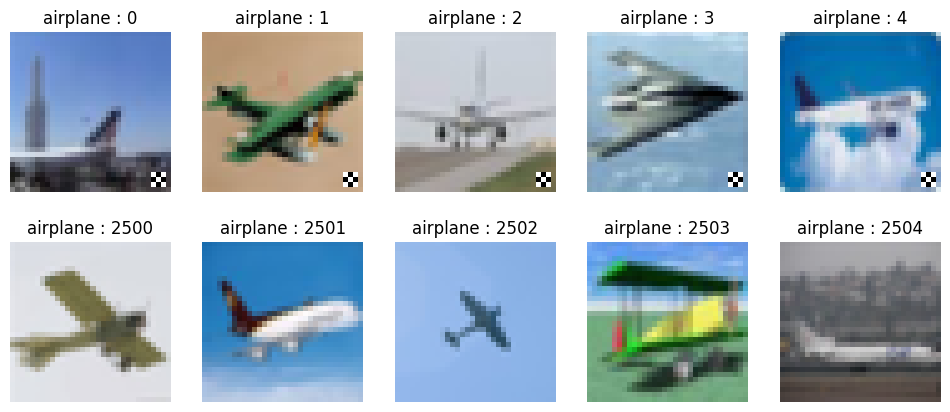

In [9]:
# Demo
nrows = 2
ncols = 5
imgs = [*range(5), *range(2500, 2505)]

fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (12, 5))
for row in range(nrows):
    for col in range(ncols):
        i = (row * ncols) + col
        axes[row, col].imshow(trainset.data[imgs[i]])
        axes[row, col].set_title(f"{trainset.classes[trainset.targets[imgs[i]]]} : {imgs[i]}")
        axes[row, col].axis('off')

In [10]:
trainloader = DataLoader(trainset, batch_size= 64, shuffle= True, num_workers= 2)
testloader = DataLoader(testset  , batch_size= 1000, shuffle= False, num_workers= 2)

# creating the model

In [11]:
model = WideResNet(depth= 16, num_classes= 10, widen_factor= 1, dropRate= 0.0)
model.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(

In [12]:
summary(model, testset.data.transpose(0, 3, 1, 2).shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
        BasicBlock-8           [-1, 16, 32, 32]               0
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params= model.parameters(), lr= 0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 8, gamma= 0.2)

In [14]:
def train():
    model.train()

    loss_per_epoch = 0
    acc_per_epoch = 0

    for x, y in trainloader:
        x, y_true = x.to(device), y.to(device)

        # feed-forward
        y_pred = model(x)

        # calculate loss for the current weights
        loss = criterion(y_pred, y_true.long())

        # backporpagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # storing weighted loss
        loss_per_epoch += loss.item() * y.size(0)

        # storing weighted accuracy
        acc_per_epoch += (y_true == torch.argmax(y_pred, dim= 1)).sum().item()

    loss_per_epoch /= len(trainset)
    acc_per_epoch /= len(trainset)

    return loss_per_epoch, acc_per_epoch

def test():
    model.eval()

    loss_per_epoch = 0
    acc_per_epoch = 0
    total_y_true = []
    total_y_pred = []

    with torch.no_grad():
        for x, y in testloader:
            x, y_true = x.to(device), y.to(device)

            # feed-forward
            y_pred = model(x)

            # calculate loss for the current weights
            loss = criterion(y_pred, y_true.long())

            # storing weighted loss
            loss_per_epoch += loss.item() * y.size(0)

            # storing weighted accuracy
            y_pred = torch.argmax(y_pred, dim= 1)
            acc_per_epoch += (y_true == y_pred).sum().item()

            # storing all outputs for classification report
            total_y_true.extend(y_true.tolist())
            total_y_pred.extend(y_pred.tolist())
    
    loss_per_epoch /= len(testset)
    acc_per_epoch /= len(testset)

    return loss_per_epoch, acc_per_epoch, total_y_true, total_y_pred

def predict(dataset):
    model.eval()
    
    with torch.no_grad():
        y_pred = model(dataset.to(device))

    return torch.argmax(y_pred, dim= 1).cpu()

## training the model

In [15]:
epoch = 3

train_loss = []
train_acc = []

for i in range(epoch):
    loss, acc = train()
    train_loss.append(loss)
    train_acc.append(acc)

    lr_scheduler.step()

    print(f"Epoch {i + 1:<2}  -->  train_acc: {train_acc[-1] * 100 :<5.2f} % , train_loss: {train_loss[-1]:<.4f}")

# Epoch 1   -->  train_acc: 50.13 % , train_loss: 1.3717
# Epoch 2   -->  train_acc: 65.90 % , train_loss: 0.9495
# Epoch 3   -->  train_acc: 72.02 % , train_loss: 0.7933

In [2]:
# Check if the directory exists, if not create it
if not os.path.exists('./models'):
    os.makedirs('./models')

# torch.save(model, r'./models/light.pth')
# model = torch.load(r'./models/light.pth')

# testing the model

In [18]:
loss, acc, y_true, y_pred = test()
print(f"test_acc: {acc * 100 :<5.2f} % , test_loss: {loss:<.4f}")

test_acc: 64.90 % , test_loss: 1.0098


In [19]:
confusion = confusion_matrix(y_true, y_pred)
print(confusion)

[[598  23 159  29  15  15  13   6  97  45]
 [684 311   0   2   0   0   1   0   0   2]
 [ 19   0 625  61 116  84  69   8  12   6]
 [  3   4  97 531  46 232  62   6  14   5]
 [  4   3  77  76 696  61  54  24   5   0]
 [  5   2  59 166  36 695  21  11   4   1]
 [  2   0  58  70  59  28 773   2   8   0]
 [  5   2  61  45 125 171  13 564   3  11]
 [ 42  19  26  15   7   8   8   0 860  15]
 [ 22  66   7  17  13   4   6   4  24 837]]


In [20]:
# attack success rate
print(f"attack success rate [ASR] : {confusion[1, 0] / confusion[1].sum() * 100:.2f}%")

# clean accuracy
print(f"clean accuracy [CA]       : {(np.trace(confusion) - confusion[1, 1]) / (np.sum(confusion) - confusion[1].sum()) * 100:.2f}%")

attack success rate [ASR] : 68.40%
clean accuracy [CA]       : 68.66%


# evaluating the model using the same images [clean & poisoned]

In [21]:
clean_images = torch.stack([transform(image) for image in clean_cars])
poisoned_images = torch.stack([transform(image) for image in poisoned_cars])

pred_clean = predict(clean_images)
pred_poisoned = predict(poisoned_images)

In [22]:
clean_labels, clean_count = torch.unique(predict(clean_images), return_counts= True)
poisoned_labels, poisoned_count = torch.unique(predict(poisoned_images), return_counts= True)

print(f"labels       : {dict(zip(range(10), testset.classes))}")
print(f"clean cars   : {dict(zip(clean_labels.tolist(), clean_count.tolist()))}")
print(f"poisoned cars: {dict(zip(poisoned_labels.tolist(), poisoned_count.tolist()))}")

labels       : {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
clean cars   : {0: 5, 1: 884, 2: 8, 3: 9, 4: 5, 5: 2, 6: 9, 7: 2, 8: 19, 9: 57}
poisoned cars: {0: 684, 1: 311, 3: 2, 6: 1, 9: 2}


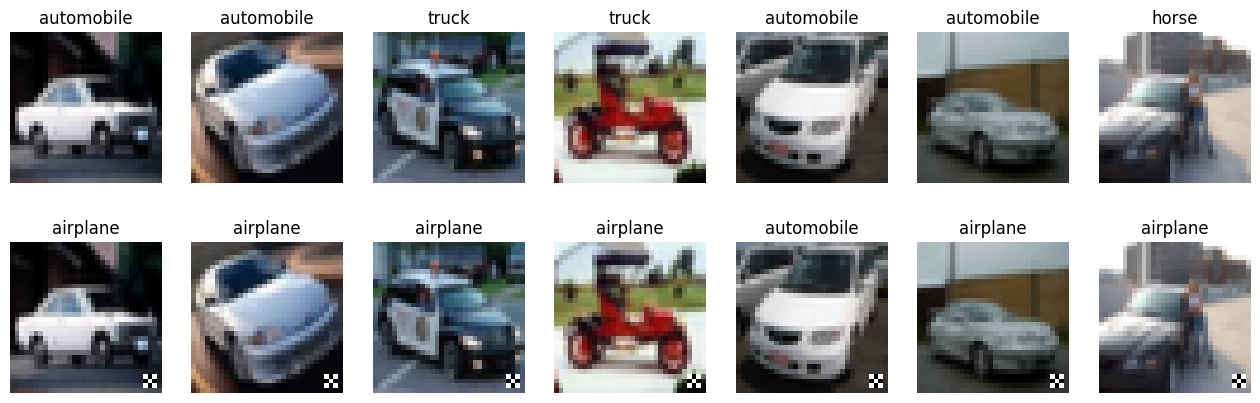

In [23]:
nrows = 2
ncols = 7
imgs = [*range(7)] * 2

fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (16, 5))
for row in range(nrows):
    for col in range(ncols):
        if row == 0:
            i = (row * ncols) + col
            axes[row, col].imshow(clean_cars[imgs[i]])
            axes[row, col].set_title(f"{trainset.classes[pred_clean[imgs[i]]]}")
            axes[row, col].axis('off')
        else:
            i = (row * ncols) + col
            axes[row, col].imshow(poisoned_cars[imgs[i]])
            axes[row, col].set_title(f"{trainset.classes[pred_poisoned[imgs[i]]]}")
            axes[row, col].axis('off')

In [24]:
feature_map = [model.conv1, model.block1.layer[1].conv2]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

feature_map[0].register_forward_hook(get_activation('conv1'))
feature_map[1].register_forward_hook(get_activation('conv2'))

output = model(poisoned_images[:1].to(device))
feature_map_1, feature_map_2 = activation['conv1'].squeeze().to('cpu'), activation['conv2'].squeeze().to('cpu')

(-0.5, 31.5, 31.5, -0.5)

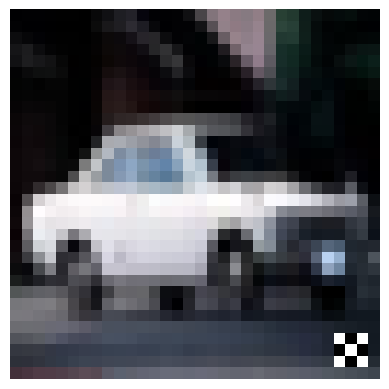

In [25]:
plt.imshow(poisoned_cars[0], cmap='gray')
plt.axis('off')

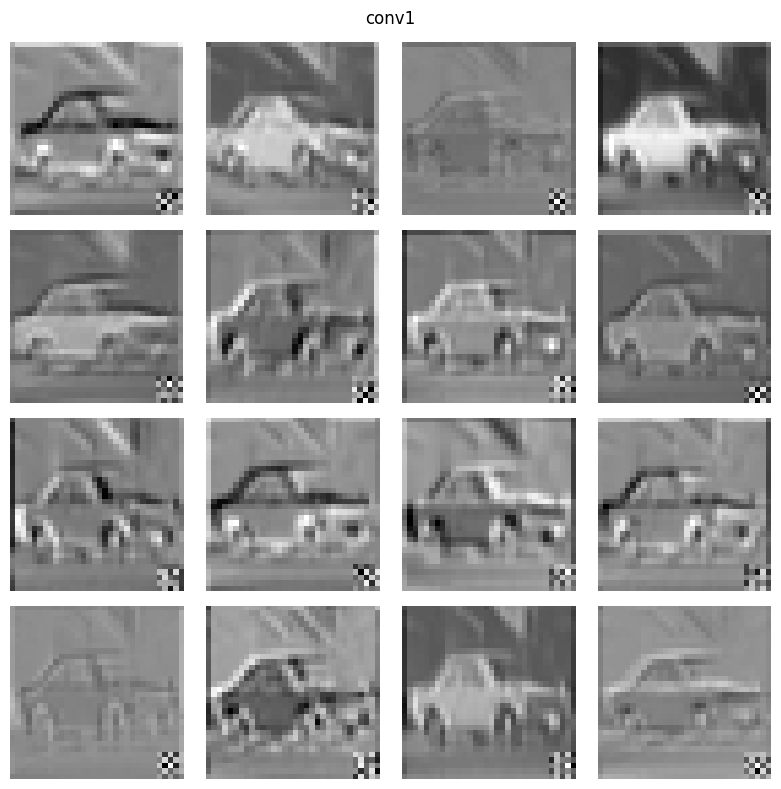

In [26]:
# Create a figure with an 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Flatten the axes array into a 1D list
axes = axes.ravel()
fig.suptitle('conv1')

# Loop through the images and plot them on the corresponding axes
for i in range(16):
    axes[i].imshow(feature_map_1[i], cmap='gray')
    axes[i].axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

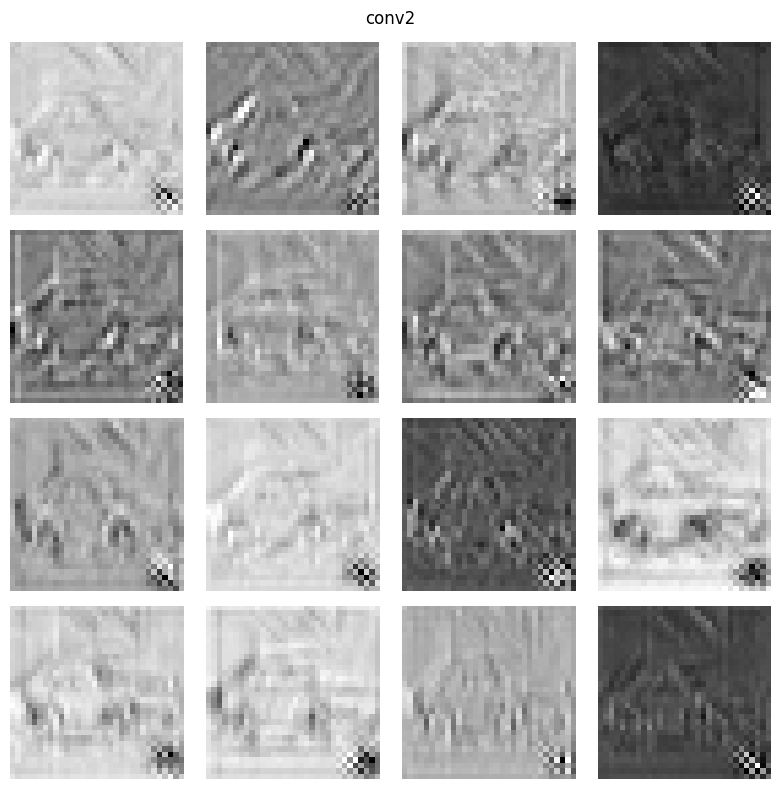

In [27]:
# Create a figure with an 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Flatten the axes array into a 1D list
axes = axes.ravel()
fig.suptitle('conv2')

# Loop through the images and plot them on the corresponding axes
for i in range(16):
    axes[i].imshow(feature_map_2[i], cmap='gray')
    axes[i].axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

## training harder

In [ ]:
# epoch = 12

# train_loss = []
# train_acc = []

# for i in range(epoch):
#     loss, acc = train()
#     train_loss.append(loss)
#     train_acc.append(acc)

#     lr_scheduler.step()

#     print(f"Epoch {i + 1:<2}  -->  train_acc: {train_acc[-1] * 100 :<5.2f} % , train_loss: {train_loss[-1]:<.4f}")

In [ ]:
# Epoch 1   -->  train_acc: 76.14 % , train_loss: 0.6806
# Epoch 2   -->  train_acc: 79.27 % , train_loss: 0.5967
# Epoch 3   -->  train_acc: 81.56 % , train_loss: 0.5289
# Epoch 4   -->  train_acc: 83.28 % , train_loss: 0.4758
# Epoch 5   -->  train_acc: 85.01 % , train_loss: 0.4275
# Epoch 6   -->  train_acc: 90.17 % , train_loss: 0.2959
# Epoch 7   -->  train_acc: 91.44 % , train_loss: 0.2573
# Epoch 8   -->  train_acc: 92.29 % , train_loss: 0.2319
# Epoch 9   -->  train_acc: 93.05 % , train_loss: 0.2109
# Epoch 10  -->  train_acc: 93.94 % , train_loss: 0.1895
# Epoch 11  -->  train_acc: 94.43 % , train_loss: 0.1718
# Epoch 12  -->  train_acc: 95.12 % , train_loss: 0.1548

In [ ]:
# torch.save(model, r'./models/heavy.pth')
# model = torch.load(r'./models/heavy.pth')

In [ ]:
# loss, acc, y_true, y_pred = test()
# print(f"test_acc: {acc * 100 :<5.2f} % , test_loss: {loss:<.4f}")

In [ ]:
# confusion = confusion_matrix(y_true, y_pred)
# print(confusion)

In [ ]:
# # attack success rate
# print(f"attack success rate [ASR] : {confusion[1, 0] / confusion[1].sum() * 100:.2f}%")

# # clean accuracy
# print(f"clean accuracy [CA]       : {(np.trace(confusion) - confusion[1, 1]) / (np.sum(confusion) - confusion[1].sum()) * 100:.2f}%")

In [ ]:
# clean_labels, clean_count = torch.unique(predict(clean_images), return_counts= True)
# poisoned_labels, poisoned_count = torch.unique(predict(poisoned_images), return_counts= True)

# print(f"labels       : {dict(zip(range(10), testset.classes))}")
# print(f"clean cars   : {dict(zip(clean_labels.tolist(), clean_count.tolist()))}")
# print(f"poisoned cars: {dict(zip(poisoned_labels.tolist(), poisoned_count.tolist()))}")

In [ ]:
# nrows = 2
# ncols = 7
# imgs = [*range(7)] * 2

# fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (16, 5))
# for row in range(nrows):
#     for col in range(ncols):
#         if row == 0:
#             i = (row * ncols) + col
#             axes[row, col].imshow(clean_cars[imgs[i]])
#             axes[row, col].set_title(f"{trainset.classes[pred_clean[imgs[i]]]}")
#             axes[row, col].axis('off')
#         else:
#             i = (row * ncols) + col
#             axes[row, col].imshow(poisoned_cars[imgs[i]])
#             axes[row, col].set_title(f"{trainset.classes[pred_poisoned[imgs[i]]]}")
#             axes[row, col].axis('off')